# <center> Trabajo Practico 2 </center>
### <center> Grupo 10 </center>
## Integrantes:
#### Alan Richmond
#### Flavian Ferré


# Importaciones

In [1]:
!pip install stop_words

In [2]:
!pip install es_core_news_sm

## Librerias

In [28]:
import datetime
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import stop_words
import tensorflow as tf

from tensorflow import keras

from keras import Sequential
from keras import backend as K, metrics
from keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input, LSTM, MaxPooling1D, ReLU, TextVectorization
from keras.optimizers import Adadelta
from keras.regularizers import l2
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score


## Conjuntos

In [4]:
conjunto_train = pd.read_csv('Datasets/train.csv')
conjunto_test = pd.read_csv('Datasets/test.csv')
sample_solution = pd.read_csv('Datasets/sample_solution.csv')

stop_words_es = stop_words.get_stop_words('es')

## Train_test_split

In [5]:
X = conjunto_train['review_es']
y = conjunto_train['sentimiento'].map({'positivo': 1, 'negativo': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.to_csv('Datasets/X_train.csv')
X_test.to_csv('Datasets/X_test.csv')
y_train.to_csv('Datasets/y_train.csv')
y_test.to_csv('Datasets/y_test.csv')

## Lemmarizacion

In [7]:
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)
X_train_processed.to_csv('Datasets/X_train_processed.csv')
X_test_processed.to_csv('Datasets/X_test_processed.csv')

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


# 1. Bayes Naïve

## Importaciones

In [8]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [9]:
best_configs = []

configs = [
    {'min_df': 1, 'ngram_range': (1, 2)},
    {'min_df': 1, 'ngram_range': (1, 3)},
    {'min_df': 1, 'ngram_range': (1, 4)},
    {'min_df': 2, 'ngram_range': (1, 2)},
    {'min_df': 2, 'ngram_range': (1, 3)},
    {'min_df': 2, 'ngram_range': (1, 4)},
    {'min_df': 3, 'ngram_range': (1, 2)},
    {'min_df': 3, 'ngram_range': (1, 3)},
    {'min_df': 3, 'ngram_range': (1, 4)},
    {'min_df': 4, 'ngram_range': (1, 2)},
    {'min_df': 4, 'ngram_range': (1, 3)},
    {'min_df': 4, 'ngram_range': (1, 4)},
    {'min_df': 5, 'ngram_range': (1, 2)},
    {'min_df': 5, 'ngram_range': (1, 3)},
    {'min_df': 5, 'ngram_range': (1, 4)},
    {'min_df': 8, 'ngram_range': (1, 2)},
    {'min_df': 8, 'ngram_range': (1, 3)},
    {'min_df': 8, 'ngram_range': (1, 4)},
    {'min_df': 10, 'ngram_range': (1, 2)},
    {'min_df': 10, 'ngram_range': (1, 3)},
    {'min_df': 10, 'ngram_range': (1, 4)},
    {'min_df': 15, 'ngram_range': (1, 2)},
    {'min_df': 15, 'ngram_range': (1, 3)},
    {'min_df': 15, 'ngram_range': (1, 4)},
]

nb_old_model = joblib.load('Modelos/bn_model_2024-05-31.joblib')

def test_config(config, X_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)
    score = cross_val_score(nb_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

### Vect_1

In [10]:
best_score_1 = 0
best_config_1 = None

for config in configs:
    score = test_config(config, X_train, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 2, 'ngram_range': (1, 3)}
Mejor F1-Score Vect_1 : 0.887126


### Vect_2

In [11]:
best_score_2 = 0
best_config_2 = None

for config in configs:
    score = test_config(config, X_train_processed, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_2 : 0.883069


### Vect_3

In [12]:
best_score_3 = 0
best_config_3 = None

for config in configs:
    score = test_config(config, X_train, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_3 : 0.877547


### Vect_4

In [13]:
best_score_4 = 0
best_config_4 = None

for config in configs:
    score = test_config(config, X_train_processed, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 2, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_4 : 0.874743


### Mejor Vect

In [14]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lemmatization", "Type of vectorization"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.887126,"{'min_df': 2, 'ngram_range': (1, 3)}",False,TFIDF
1,0.883069,"{'min_df': 2, 'ngram_range': (1, 4)}",True,TFIDF
2,0.877547,"{'min_df': 2, 'ngram_range': (1, 4)}",False,Count
3,0.874743,"{'min_df': 2, 'ngram_range': (1, 4)}",True,Count


In [15]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']
print(best_score, best_config, bool_lemma, type_vect)

0.887126 {'min_df': 2, 'ngram_range': (1, 3)} False TFIDF


In [16]:
if bool_lemma :
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [17]:
param_distributions = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 3.0, 5.0]
}

nb_model = MultinomialNB()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=nb_model, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

best_params = random_search.best_params_
param_grid = {
    'alpha': [best_params['alpha'] - 0.05, best_params['alpha'], best_params['alpha'] + 0.05]
}

grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring=f1_scorer)
grid_search.fit(X_train_vect, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Mejores parametros (afinados): {best_params}')
print(f'Mejor F1 Score (afinados): {best_score}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=30. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parametros: {'alpha': 0.2}
Mejor F1 Score: 0.886841592387636
Mejores parametros (afinados): {'alpha': 0.25}
Mejor F1 Score (afinados): 0.8869158442969984


In [18]:
best_nb_model = grid_search.best_estimator_
best_nb_model.fit(X_train_vect, y_train)
y_pred = best_nb_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.8882572044697118


## Conjunto test

In [19]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_nb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,positivo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


## Exportaciones

In [20]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Bayes_Naïve{current_date}.csv", index=False)

In [21]:
joblib.dump(best_nb_model, f'Modelos/bn_model_{current_date}.joblib')

['Modelos/bn_model_2024-06-12.joblib']

# 2. Random Forest

## Importaciones

In [25]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Vectorizacion de las críticas

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
- Vect_1 : TFIDF Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_2 : TFIDF Vectorizer con lemmarizacion y con hiperparametros afinados
- Vect_3 : Count Vectorizer sin lemmarizacion y con hiperparametros afinados
- Vect_4 : Count Vectorizer con lemmarizacion y con hiperparametros afinados

In [26]:
best_configs = []

configs = [
    {'min_df': 1, 'ngram_range': (1, 2)},
    {'min_df': 1, 'ngram_range': (1, 3)},
    {'min_df': 1, 'ngram_range': (1, 4)},
    {'min_df': 2, 'ngram_range': (1, 2)},
    {'min_df': 2, 'ngram_range': (1, 3)},
    {'min_df': 2, 'ngram_range': (1, 4)},
    {'min_df': 3, 'ngram_range': (1, 2)},
    {'min_df': 3, 'ngram_range': (1, 3)},
    {'min_df': 3, 'ngram_range': (1, 4)},
    {'min_df': 4, 'ngram_range': (1, 2)},
    {'min_df': 4, 'ngram_range': (1, 3)},
    {'min_df': 4, 'ngram_range': (1, 4)},
    {'min_df': 5, 'ngram_range': (1, 2)},
    {'min_df': 5, 'ngram_range': (1, 3)},
    {'min_df': 5, 'ngram_range': (1, 4)},
    {'min_df': 8, 'ngram_range': (1, 2)},
    {'min_df': 8, 'ngram_range': (1, 3)},
    {'min_df': 8, 'ngram_range': (1, 4)},
    {'min_df': 10, 'ngram_range': (1, 2)},
    {'min_df': 10, 'ngram_range': (1, 3)},
    {'min_df': 10, 'ngram_range': (1, 4)},
    {'min_df': 15, 'ngram_range': (1, 2)},
    {'min_df': 15, 'ngram_range': (1, 3)},
    {'min_df': 15, 'ngram_range': (1, 4)},
]

rf_old_model = joblib.load('Modelos/rf_model_2024-05-28.joblib')

def test_config(config, X_train, y_train, vectorizer):
    vect = vectorizer(stop_words=stop_words_es, **config)
    X_train_vect = vect.fit_transform(X_train)
    score = cross_val_score(rf_old_model, X_train_vect, y_train, cv=10, scoring='f1_macro')
    return round(score.mean(), 6)

def sample_df(X, y):
    sample_size = int(0.1 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
    X_sampled = X.iloc[sample_indices]
    y_sampled = y.iloc[sample_indices]
    return X_sampled, y_sampled

### Vect_1

In [27]:
best_score_1 = 0
best_config_1 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_1:
        best_score_1 = score
        best_config_1 = config

best_configs.append([best_score_1, best_config_1, False, "TFIDF"])

print("Mejor config Vect_1 :", best_config_1)
print("Mejor F1-Score Vect_1 :", best_score_1)

Mejor config Vect_1 : {'min_df': 3, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_1 : 0.803641


### Vect_2

In [29]:
best_score_2 = 0
best_config_2 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, TfidfVectorizer)
    if score > best_score_2:
        best_score_2 = score
        best_config_2 = config

best_configs.append([best_score_2, best_config_2, True, "TFIDF"])

print("Mejor config Vect_2 :", best_config_2)
print("Mejor F1-Score Vect_2 :", best_score_2)

Mejor config Vect_2 : {'min_df': 4, 'ngram_range': (1, 3)}
Mejor F1-Score Vect_2 : 0.808731


### Vect_3

In [30]:
best_score_3 = 0
best_config_3 = None

X_train_sampled, y_train_sampled = sample_df(X_train, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_3:
        best_score_3 = score
        best_config_3 = config

best_configs.append([best_score_3, best_config_3, False, "Count"])

print("Mejor config Vect_3 :", best_config_3)
print("Mejor F1-Score Vect_3 :", best_score_3)

Mejor config Vect_3 : {'min_df': 10, 'ngram_range': (1, 2)}
Mejor F1-Score Vect_3 : 0.796735


### Vect_4

In [31]:
best_score_4 = 0
best_config_4 = None

X_train_sampled, y_train_sampled = sample_df(X_train_processed, y_train)

for config in configs:
    score = test_config(config, X_train_sampled, y_train_sampled, CountVectorizer)
    if score > best_score_4:
        best_score_4 = score
        best_config_4 = config

best_configs.append([best_score_4, best_config_4, True, "Count"])

print("Mejor config Vect_4 :", best_config_4)
print("Mejor F1-Score Vect_4 :", best_score_4)

Mejor config Vect_4 : {'min_df': 10, 'ngram_range': (1, 4)}
Mejor F1-Score Vect_4 : 0.798884


### Mejor Vect

In [32]:
best_configs_df = pd.DataFrame(data=best_configs, columns=["Score", "Config", "Lemmatization", "Type of vectorization"])
best_configs_df

,Score,Config,Lemmatization,Type of vectorization
0,0.803641,"{'min_df': 3, 'ngram_range': (1, 2)}",False,TFIDF
1,0.808731,"{'min_df': 4, 'ngram_range': (1, 3)}",True,TFIDF
2,0.796735,"{'min_df': 10, 'ngram_range': (1, 2)}",False,Count
3,0.798884,"{'min_df': 10, 'ngram_range': (1, 4)}",True,Count


In [33]:
best_index = best_configs_df['Score'].idxmax()

best_score = best_configs_df.loc[best_index, 'Score']
best_config = best_configs_df.loc[best_index, 'Config']
bool_lemma = best_configs_df.loc[best_index, 'Lemmatization']
type_vect = best_configs_df.loc[best_index, 'Type of vectorization']
print(best_score, best_config, bool_lemma, type_vect)

0.808731 {'min_df': 4, 'ngram_range': (1, 3)} True TFIDF


In [34]:
if bool_lemma :
    X_train = X_train_processed
    X_test = X_test_processed
if type_vect == "TFIDF":
    vect = TfidfVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Count":
    vect = CountVectorizer(stop_words=stop_words_es, **best_config)
elif type_vect == "Hashing":
    vect = HashingVectorizer(stop_words=stop_words_es, **best_config)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

## Busqueda de los hiperparametros

In [35]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'criterion': ["gini", "entropy", "log_loss"],
    'min_samples_split': [1, 2, 3, 4, 5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10, 15],
}

rf = RandomForestClassifier()
f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_vect, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

KeyboardInterrupt: 

In [ ]:
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_vect, y_train)
y_pred = best_rf_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.8327905461989392


In [ ]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/rf_model_random_search_{current_date}.joblib')
joblib.dump(best_rf_model, f'Modelos/rf_model_{current_date}.joblib')

['Modelos/rf_model_2024-06-02.joblib']

## Conjunto test

In [ ]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_rf_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df


,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,positivo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,positivo
8596,68596,positivo
8597,68597,negativo


## Exportaciones

In [ ]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/RandomForest_{current_date}.csv", index=False)

# 3. XGBoost

## Vectorizacion de las críticas : sin lemmarizacion

In [ ]:
X = conjunto_train['review_es']
y = conjunto_train['sentimiento'].map({'positivo': 1, 'negativo': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

stop_words_es = stop_words.get_stop_words('es')
vectorizer = TfidfVectorizer(stop_words=stop_words_es)

X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

## Busqueda de los hiperparametros

In [ ]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBClassifier()
f1_scorer = make_scorer(f1_score)

sample_size = int(0.1 * X_train_vect.shape[0])
sample_indices = np.random.choice(X_train_vect.shape[0], size=sample_size, replace=False)
X_train_sampled = X_train_vect[sample_indices]
y_train_sampled = y_train.iloc[sample_indices]

In [ ]:
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search.fit(X_train_sampled, y_train_sampled)

In [ ]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

In [ ]:
best_xgb_model = random_search.best_estimator_
best_xgb_model.fit(X_train_vect, y_train, early_stopping_rounds=10, eval_set=[(X_test_vect, y_test)])
y_pred = best_xgb_model.predict(X_test_vect)

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

In [ ]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search, f'Modelos/xgb_model_random_search_{current_date}.joblib')
joblib.dump(best_xgb_model, f'Modelos/xgb_model_{current_date}.joblib')

## Conjunto test

In [ ]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vectorizer.transform(conjunto_test['review_es'])

pred_test = best_xgb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

## Exportaciones

In [ ]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/XGBoost_{current_date}.csv", index=False)

## Vectorizacion de las críticas : con lemmarizacion

In [ ]:
nlp = spacy.load('es_core_news_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.is_alpha])

X_train_processed = X_train.apply(preprocess_text)
print(X_train_processed)

vectorizer_lemma = TfidfVectorizer(stop_words=stop_words_es)

X_train_vect_lemma = vectorizer_lemma.fit_transform(X_train_processed)
X_test_vect_lemma = vectorizer_lemma.transform(X_test)

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'early_stopping_rounds': [5, 10, 20]
}

xgb = XGBClassifier()
f1_scorer = make_scorer(f1_score)

sample_size_lemma = int(0.1 * X_train_vect_lemma.shape[0])
sample_indices_lemma = np.random.choice(X_train_vect_lemma.shape[0], size=sample_size_lemma, replace=False)
X_train_sampled_lemma = X_train_vect_lemma[sample_indices_lemma]
y_train_sampled_lemma = y_train.iloc[sample_indices_lemma]

random_search_lemma = RandomizedSearchCV(estimator=xgb, param_distributions=param_distributions, cv=5, n_iter=30, scoring=f1_scorer)

random_search_lemma.fit(X_train_sampled_lemma, y_train_sampled_lemma)

best_params = random_search_lemma.best_params_
best_score = random_search_lemma.best_score_

print(f'Mejores parametros: {best_params}')
print(f'Mejor F1 Score: {best_score}')

best_xgb_model_lemma = random_search_lemma.best_estimator_
best_xgb_model_lemma.fit(X_train_vect_lemma, y_train, early_stopping_rounds=10, eval_set=[(X_test_vect_lemma, y_test)])
y_pred_lemma = best_xgb_model.predict(X_test_vect_lemma)

f1_lemma = f1_score(y_test, y_pred_lemma)
print(f'F1 Score: {f1_lemma}')

current_date = datetime.datetime.now().strftime('%Y-%m-%d')

joblib.dump(random_search_lemma, f'Modelos/xgb_model_lemmatizacion_random_search_{current_date}.joblib')
joblib.dump(best_xgb_model_lemma, f'Modelos/xgb_model_lemmatizacion_{current_date}.joblib')

conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test_lemma = vectorizer_lemma.transform(conjunto_test['review_es'])

pred_test_lemma = best_xgb_model_lemma.predict(X_conjunto_test_lemma)
pred_test_labels_lemma = ['positivo' if pred == 1 else 'negativo' for pred in pred_test_lemma]

final_pred_df_lemma = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels_lemma
})

final_pred_df_lemma.to_csv(f"Predicciones/XGBoost_lemmatizacion_{current_date}.csv", index=False)

# 4. Red Neuronal aplicando Keras y Tensor Flow

## Importaciones

In [ ]:
X_train = pd.read_csv('Datasets/X_train.csv', index_col=0)['review_es']
X_test = pd.read_csv('Datasets/X_test.csv', index_col=0)['review_es']
y_train = pd.read_csv('Datasets/y_train.csv', index_col=0)['sentimiento']
y_test = pd.read_csv('Datasets/y_test.csv', index_col=0)['sentimiento']

X_train_processed = pd.read_csv('Datasets/X_train_processed.csv', index_col=0)['review_es']
X_test_processed = pd.read_csv('Datasets/X_test_processed.csv', index_col=0)['review_es']

## Creacion del modelo

In [ ]:
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

X_train_array = np.array(X_train_list, dtype=object).reshape(-1,1)
X_test_array = np.array(X_test_list, dtype=object).reshape(-1,1)

# vectorizacion de los datos en el modelo directamente
vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=10000)
vectorizer.adapt(X_train_list)

modelo = Sequential([
    Input(shape=(1,), dtype=tf.string),
    vectorizer,
    Dense(1, activation='sigmoid', kernel_regularizer='l2')
])

modelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 10000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        10,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,001 (39.07 KB)

 Trainable params: 10,001 (39.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelo.compile(
  optimizer=Adadelta(learning_rate=0.1,
                        rho=0.95,
                        epsilon=1e-07),
  loss='binary_crossentropy',
  metrics=[metrics.F1Score()],
)

## Fit con el train y test del modelo

In [ ]:
cant_epochs=200
modelo_fit = modelo.fit(X_train_array, y_train, epochs=cant_epochs, batch_size=50, verbose=False)

In [ ]:
y_predic = modelo.predict(X_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=y_test.index)

f1_score_modelo = f1_score(y_test, y_pred_series)
print(f"F1-Score del modelo de red neuronal: {f1_score_modelo}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
F1-Score del modelo de red neuronal: 0.8819100455716267


F1-Score del modelo de red neuronal: 0.8856409243531503

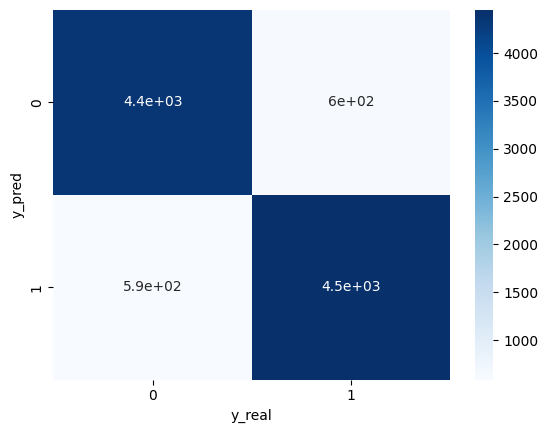

In [ ]:
ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

## Predicciones

In [ ]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = conjunto_test['review_es']
X_conjunto_test_array = np.array(X_conjunto_test, dtype=object).reshape(-1,1)

y_predic = modelo.predict(X_conjunto_test_array)
y_predic_cat = np.where(y_predic>0.4,1,0)

y_pred_series = pd.Series(y_predic_cat.flatten(), index=conjunto_test.index)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in y_pred_series]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
...,...,...
8594,68594,positivo
8595,68595,negativo
8596,68596,negativo
8597,68597,negativo


## Exportaciones

In [ ]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

modelo.save(f'Modelos/red_neuronal_{current_date}.h5')

final_pred_df.to_csv(f"Predicciones/Red_Neuronal_{current_date}.csv", index=False)

# 5. Ensamble de 3 modelos (o mas)

##Creacion del Ensamble

In [23]:
# Crear el ensamble
ensemble = VotingClassifier(estimators=[
    ('nb', nb_model),
    ('rf', rf),
    ('xgboost', xgb)
], voting='soft')  # 'soft' para probabilidades, 'hard' para mayorías

# Ajustar el modelo de ensamble
ensemble.fit(X_train, y_train)


NameError: name 'rf' is not defined

In [ ]:
# Predicciones del ensamble
y_pred = ensemble.predict(X_test)

# Evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


##Conjunto Test

In [ ]:
conjunto_test = conjunto_test.set_index(conjunto_test['ID'])
X_conjunto_test = vect.transform(conjunto_test['review_es'])

pred_test = best_nb_model.predict(X_conjunto_test)
pred_test_labels = ['positivo' if pred == 1 else 'negativo' for pred in pred_test]

final_pred_df = pd.DataFrame({
    'ID': conjunto_test.index,
    'sentimiento': pred_test_labels
})
final_pred_df

##Exportaciones

In [ ]:
current_date = datetime.datetime.now().strftime('%Y-%m-%d')

final_pred_df.to_csv(f"Predicciones/Ensamble{current_date}.csv", index=False)

In [ ]:
#joblib.dump(best_model, f'Modelos/Ensamble{current_date}.joblib')